# **문제1**

## **라이브러리**

In [166]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## **데이터 불러오기**

In [167]:
mnist = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x = train_x/255.0, test_x/255.0


# (샘플 수, 높이, 너비, 채널수)
# 흑백(밝기) 1채널
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

## **레이어 설정**

In [168]:
# input layer
input_h = 28
input_w = 28
input_ch = 1


# 1st convolution layer
# (None, 14, 14, 32)
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2


# 2nd convolution layer
# (None, 7, 7, 64)
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2


# Fully connected : flatten the features (7x7x64)
conv_result_size = 7 * 7 * 64
n_hidden = 100
n_output = 10


# Kernel size : [kernel_height, kernel_width, input_ch, output_ch]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

weights = {
    'conv1' : tf.Variable(tf.random.normal([k1_h, k1_w, input_ch, k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random.normal([conv_result_size, n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_hidden, n_output], stddev = 0.1))
}


# bias size : [output_ch] or [neuron_size]
biases = {
    'conv1' : tf.Variable(tf.random.normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random.normal([n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_output], stddev = 0.1))
}


# input layer : [batch_size, image_height, image_width, channels]
# output layer : [batch_size, class_size]
x = tf.placeholder(shape=[None, input_h, input_w, input_ch], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

## **레이어 함수 정의**

In [169]:
# 레이어 연결 함수
# [batch, height, width, channels]
def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + biases['conv1'])
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='VALID')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv2 + biases['conv2'])
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='VALID')

    maxp2_flatten = tf.reshape(maxp2, [-1, conv_result_size])

    # Fully connected
    hidden = tf.matmul(maxp2_flatten, weights['hidden']) + biases['hidden']
    hidden = tf.nn.relu(hidden)
    output = tf.matmul(hidden, weights['output']) + biases['output']

    return output

## **학습**

Iter : 0
Train Loss : 2.3770246505737305
Cost : 2.5768003463745117

Iter : 250
Train Loss : 0.592349648475647
Cost : 0.49277591705322266

Iter : 500
Train Loss : 0.23904699087142944
Cost : 0.28989994525909424

Iter : 750
Train Loss : 0.19420486688613892
Cost : 0.2096540331840515

Iter : 1000
Train Loss : 0.1034819483757019
Cost : 0.3181599974632263

Iter : 1250
Train Loss : 0.14920665323734283
Cost : 0.09357345849275589

Iter : 1500
Train Loss : 0.20158182084560394
Cost : 0.26722005009651184

Iter : 1750
Train Loss : 0.15861853957176208
Cost : 0.05447758734226227

Iter : 2000
Train Loss : 0.12634511291980743
Cost : 0.11667545139789581

Iter : 2250
Train Loss : 0.1387338489294052
Cost : 0.05509597808122635



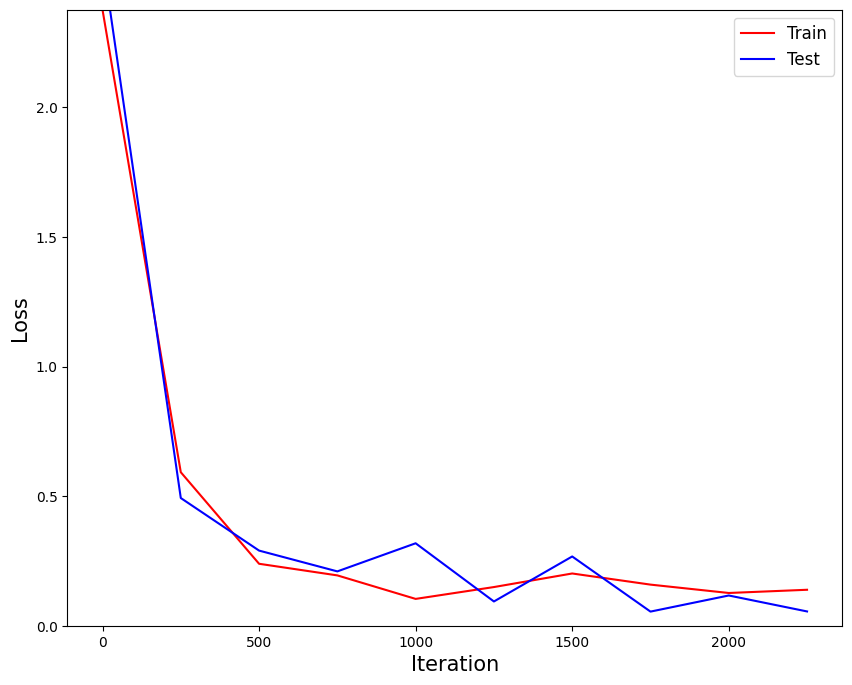

In [170]:
# Loss function
LR = 0.0001
pred = net(x, weights, biases)
loss_per_example = tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)
loss = tf.reduce_mean(loss_per_example)

optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)


# Optimization
n_batch = 50    # 한 번에 학습할 샘플 수
n_iter = 2500   # 전체 반복 횟수
n_prt = 250     # 손실을 출력할 주기

sess = tf.Session()                           # 세션 열기
sess.run(tf.global_variables_initializer())   # 초기화

loss_record_train = []  # 학습 손실 기록 리스트
loss_record_test = []   # 검증 손실 기록 리스트
for epoch in range(n_iter):
    batch_indices = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    batch_x = np.reshape(batch_x, (-1, 28, 28, 1))
    batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=10)

    sess.run(optm, feed_dict={x:batch_x, y:batch_y})

    if epoch % n_prt == 0:
        test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)
        c1 = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        c2 = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {}".format(c1))
        print("Cost : {}".format(c2), end='\n\n')

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

## **평가**

In [171]:
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

my_pred = sess.run(pred, feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_batch_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}".format(accr*100))

Accuracy : 96.0


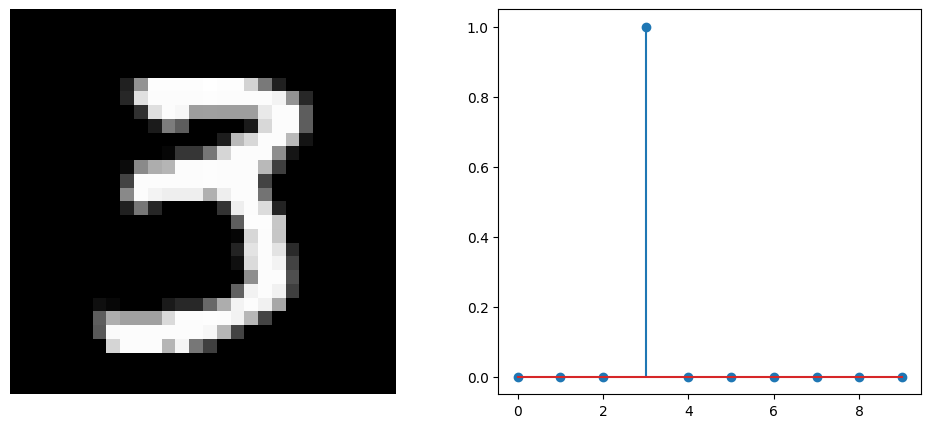

Prediction : 3
Probability : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [172]:
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

logits = sess.run(tf.nn.softmax(pred), feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.imshow(test_batch_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))

# **문제2**

## **라이브러리**

In [173]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## **데이터 불러오기**

In [174]:
mnist = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x = train_x/255.0, test_x/255.0


# (샘플 수, 높이, 너비, 채널수)
# 흑백(밝기) 1채널
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

## **레이어 설정**

In [175]:
# input layer
input_h = 28
input_w = 28
input_ch = 1


# 1st convolution layer
# (None, 14, 14, 32)
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2


# 2nd convolution layer
# (None, 7, 7, 64)
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2


# 3nd convolution layer
# (None, 4, 4, 128)
k3_h = 3
k3_w = 3
k3_ch = 128
p3_h = 2
p3_w = 2


# Fully connected : flatten the features (4x4x128)
conv_result_size = 4 * 4 * 128
n_hidden = 100
n_output = 10


# Kernel size : [kernel_height, kernel_width, input_ch, output_ch]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

weights = {
    'conv1' : tf.Variable(tf.random.normal([k1_h, k1_w, input_ch, k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev = 0.1)),
    'conv3' : tf.Variable(tf.random.normal([k3_h, k3_w, k2_ch, k3_ch], stddev = 0.1)),
    'fc1' : tf.Variable(tf.random.normal([conv_result_size, n_hidden], stddev = 0.1)),
    'fc2' : tf.Variable(tf.random.normal([n_hidden, n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_hidden, n_output], stddev = 0.1))
}


# bias size : [output_ch] or [neuron_size]
biases = {
    'conv1' : tf.Variable(tf.random.normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random.normal([k2_ch], stddev = 0.1)),
    'conv3' : tf.Variable(tf.random.normal([k3_ch], stddev = 0.1)),
    'fc1' : tf.Variable(tf.random.normal([n_hidden], stddev = 0.1)),
    'fc2' : tf.Variable(tf.random.normal([n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random.normal([n_output], stddev = 0.1))
}


# input layer : [batch_size, image_height, image_width, channels]
# output layer : [batch_size, class_size]
x = tf.placeholder(shape=[None, input_h, input_w, input_ch], dtype=tf.float32)
y = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

## **레이어 함수 정의**

In [176]:
# 레이어 연결 함수
# [batch, height, width, channels]
def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + biases['conv1'])
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='SAME')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv2 + biases['conv2'])
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='SAME')

    # 3nd convolution layer
    conv3 = tf.nn.conv2d(maxp2, weights['conv3'], strides=[1, 1, 1, 1], padding='SAME')
    conv3 = tf.nn.relu(conv3 + biases['conv3'])
    maxp3 = tf.nn.max_pool(conv3, ksize=[1, p3_h, p3_w, 1], strides=[1, p3_h, p3_w, 1], padding='SAME')

    maxp3_flatten = tf.reshape(maxp3, [-1, conv_result_size])

    # Fully connected
    hidden1 = tf.matmul(maxp3_flatten, weights['fc1']) + biases['fc1']
    hidden1 = tf.nn.relu(hidden1)

    hidden2 = tf.matmul(hidden1, weights['fc2']) + biases['fc2']
    hidden2 = tf.nn.relu(hidden2)

    output = tf.matmul(hidden2, weights['output']) + biases['output']

    return output

## **학습**

Iter : 0
Train Loss : 2.5117316246032715
Cost : 2.851036787033081

Iter : 250
Train Loss : 0.4671645760536194
Cost : 0.4513383209705353

Iter : 500
Train Loss : 0.18347664177417755
Cost : 0.13486461341381073

Iter : 750
Train Loss : 0.18909400701522827
Cost : 0.41795265674591064

Iter : 1000
Train Loss : 0.1831192821264267
Cost : 0.1098272055387497

Iter : 1250
Train Loss : 0.15001802146434784
Cost : 0.1951250433921814

Iter : 1500
Train Loss : 0.11658354848623276
Cost : 0.056042011827230453

Iter : 1750
Train Loss : 0.08819873631000519
Cost : 0.130071759223938

Iter : 2000
Train Loss : 0.15112721920013428
Cost : 0.03327472135424614

Iter : 2250
Train Loss : 0.07696641236543655
Cost : 0.22755180299282074



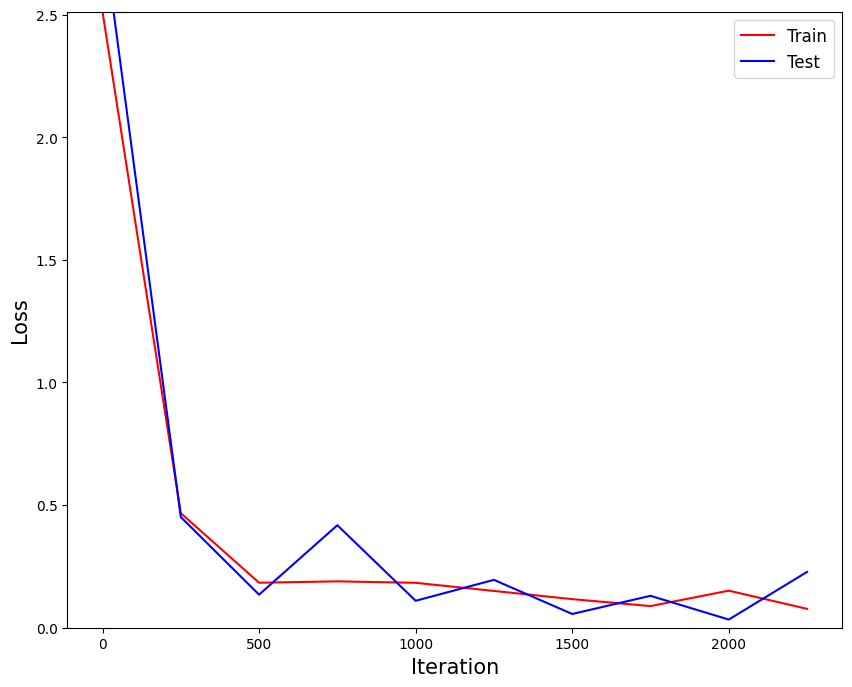

In [177]:
# Loss function
LR = 0.0001
pred = net(x, weights, biases)
loss_per_example = tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)
loss = tf.reduce_mean(loss_per_example)

optm = tf.train.AdamOptimizer(learning_rate=LR).minimize(loss)


# Optimization
n_batch = 50    # 한 번에 학습할 샘플 수
n_iter = 2500   # 전체 반복 횟수
n_prt = 250     # 손실을 출력할 주기

sess = tf.Session()                           # 세션 열기
sess.run(tf.global_variables_initializer())   # 초기화

loss_record_train = []  # 학습 손실 기록 리스트
loss_record_test = []   # 검증 손실 기록 리스트
for epoch in range(n_iter):
    batch_indices = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    batch_x = np.reshape(batch_x, (-1, 28, 28, 1))
    batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=10)

    sess.run(optm, feed_dict={x:batch_x, y:batch_y})

    if epoch % n_prt == 0:
        test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)
        c1 = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        c2 = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {}".format(c1))
        print("Cost : {}".format(c2), end='\n\n')

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

## **평가**

In [178]:
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

my_pred = sess.run(pred, feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_batch_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}".format(accr*100))

Accuracy : 98.0


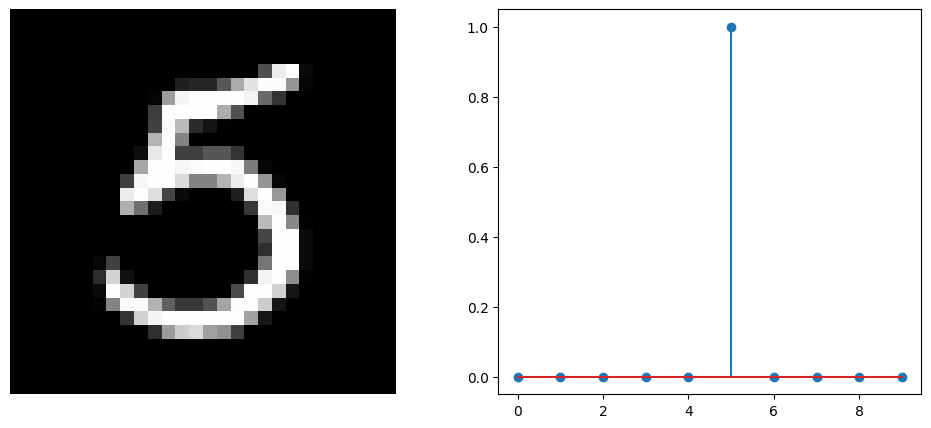

Prediction : 5
Probability : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [179]:
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

logits = sess.run(tf.nn.softmax(pred), feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.imshow(test_batch_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))